# Cooling Tank Model Optimization


**DISCLAIMER: Optimization modules do not work currently, see RAD-225**

This notebook demonstrates the optimization of the tank model described in `tank_optimization_model.py` using the `ProblemInterface` class in the `fmdtools.search` module. This is identical to `tank_opt.py` in functionality.

Note that this problem/notebook was adapted from the identical problem here: https://github.com/DesignEngrLab/resil_opt_examples/tree/main/Cooling%20Tank%20Problem, which shows more comparisions of these architectures. 

In [1]:
import numpy as np
import time
import pandas as pd

import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import fmdtools.sim.search as search
from tank_optimization_model import Tank
import matplotlib.pyplot as plt
from fmdtools.sim.approach import SampleApproach

from fmdtools.analyze.graph import ModelFxnGraph
from fmdtools.analyze.graph import ModelGraph


# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs. Flows will be constant and no signal is on.

In [2]:
mdl = Tank()
result, mdlhist = propagate.nominal(mdl,track='all', desired_result={'graph':ModelGraph})

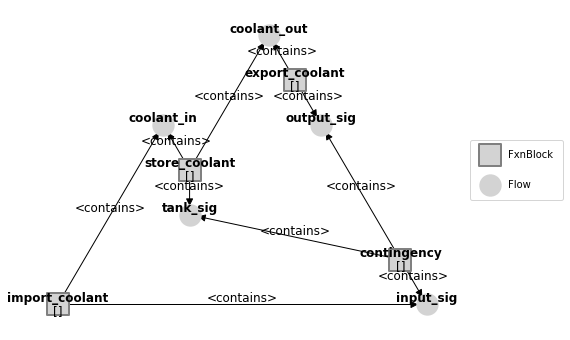

In [3]:
fig = result.graph.draw(figsize=(8,6))

In [4]:
mdlhist

fxns.import_coolant.s.amt_open: array(21)
fxns.import_coolant.m.faults.stuck: array(21)
fxns.import_coolant.m.faults.blockage: array(21)
fxns.import_coolant.m.mode:    array(21)
fxns.store_coolant.s.level:    array(21)
fxns.store_coolant.s.net_flow: array(21)
fxns.store_coolant.s.coolingbuffer: array(21)
fxns.store_coolant.m.faults.leak: array(21)
fxns.store_coolant.m.mode:     array(21)
fxns.export_coolant.s.amt_open: array(21)
fxns.export_coolant.m.faults.stuck: array(21)
fxns.export_coolant.m.faults.blockage: array(21)
fxns.export_coolant.m.mode:    array(21)
fxns.contingency.m.mode:       array(21)
flows.coolant_in.s.effort:     array(21)
flows.coolant_in.s.rate:       array(21)
flows.coolant_out.s.effort:    array(21)
flows.coolant_out.s.rate:      array(21)
flows.input_sig.s.indicator:   array(21)
flows.input_sig.s.action:      array(21)
flows.tank_sig.s.indicator:    array(21)
flows.tank_sig.s.action:       array(21)
flows.output_sig.s.indicator:  array(21)
flows.output_sig.s.ac

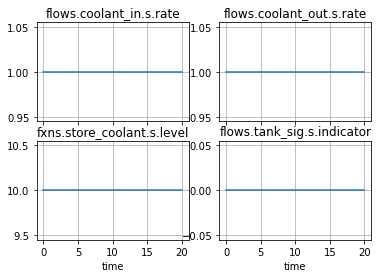

In [5]:
fig, ax =an.plot.hist(mdlhist ,'flows.coolant_in.s.rate', 
                               'flows.coolant_out.s.rate', 
                               'fxns.store_coolant.s.level', 
                               'flows.tank_sig.s.indicator')

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

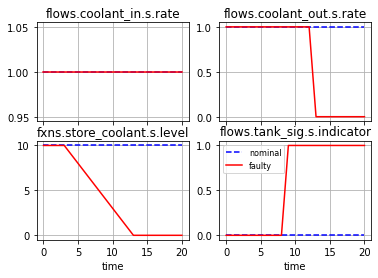

In [6]:
resgraph, mdlhist = propagate.one_fault(mdl,'store_coolant','leak', time=3, track='all',desired_result=['graph','endclass','endfaults'])

fig, ax =an.plot.hist(mdlhist ,'flows.coolant_in.s.rate', 
                               'flows.coolant_out.s.rate', 
                               'fxns.store_coolant.s.level', 
                               'flows.tank_sig.s.indicator')

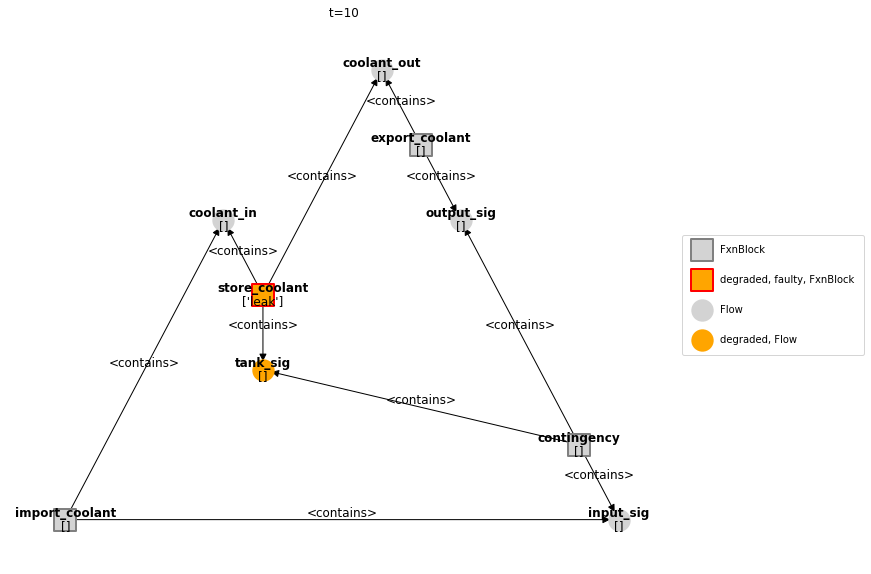

In [7]:
mg = ModelGraph(mdl)
fig, ax = mg.draw_from(10,mdlhist)

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [8]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = an.tabulate.result_summary_fmea(endclasses,mdlhists)
fmea_tab


SCENARIOS COMPLETE: 100%|██████████| 5/5 [00:00<00:00, 114.06it/s]


,degraded,faulty,rate,cost,expected cost
export_coolant_stuck_t0p0,[],[],0.000002,0.0,0.0
export_coolant_blockage_t0p0,[],[],0.000002,100000.0,16666.666667
store_coolant_leak_t0p0,[],[],0.000002,1000000.0,166666.666667
nominal,[],[],1.0,0.0,0.0
import_coolant_stuck_t0p0,[],[],0.000002,0.0,0.0
import_coolant_blockage_t0p0,[],[],0.000002,2100000.0,350000.0


### Defining Optimization Problem

We can define an optimization problem around this model using the `ProblemInterface` class.

In this case, we consider the joint minimization of design cost (defined in a function) and resilience cost (expected cost over the above list of scenarios). This is over two sets of variables

- capacity and turnup (design variables that effect both design and resilience costs), and
- the resilience policy (variables that only effect resilience cost)

In [9]:
mdl= Tank()
prob = search.ProblemInterface("res_problem", mdl, staged=True)

To model design cost (which does not involve simulation), we attach an external callable using the "external" option in `.add_simulation`. Note that this callable is defined in terms of its objective only.

In [10]:
def x_to_descost(xdes):
    pen = 0 #determining upper-level penalty
    if xdes[0]<10: pen+=1e5*(10-xdes[0])**2
    if xdes[0]>100: pen+=1e5*(100-xdes[0])**2
    if xdes[1]<0: pen+=1e5*(xdes[1])**2
    if xdes[1]>1: pen+=1e5*(1-xdes[1])**2
    return (xdes[0]-10)*1000 + (xdes[0]-10)**2*1000   + xdes[1]**2*10000 + pen
prob.add_simulation("des_cost", "external", x_to_descost)
prob.add_objectives("des_cost", cd="cd")
prob.add_variables("des_cost",'capacity', 'turnup')

In [11]:
prob

Problem res_problem                                                     current value
 Variables
 -vars capacity at t=0: None                                                      nan
 -vars turnup at t=0: None                                                        nan
 Objectives
 -cd: +(des_cost   at t=)                                                         nan
 Constraints
 -
 Simulations
 -des_cost: external scen: 

Since the design variables affect both design and resilience costs, we can use the `upstream_sims` option to translate "des_cost" variables into "res_sim" simulation parameters. 

In [12]:
from examples.tank.tank_optimization_model import Tank, TankParam, make_tankparam
app = SampleApproach(mdl)
prob.add_simulation("res_sim", "multi", app.scenlist, include_nominal=True,
                    upstream_sims = {"des_cost":{'p':{"capacity":"capacity", "turnup":"turnup"}}})

res_vars_i = {(v[0],v[1],v[2],v[3]):1 for v in mdl.p.faultpolicy}
res_vars = [(var, None) for var in res_vars_i.keys()]
[v[:4] for v in TankParam().faultpolicy]

prob.add_variables("res_sim", *res_vars, vartype=make_tankparam)
prob.add_objectives("res_sim", cost="expected cost", objtype="endclass")

Finally, to get a callable for both objectives, we can use `add_combined_objective`, which will perform an opteration (default is sum) to combine the objectives:

In [13]:
prob.add_combined_objective('tot_cost', 'cd', 'cost')

The problem is now updated to incorporate the new design variables based on fault policies. There are combinations of fault signals (triplets of -1, 0, and 1) paired with the contigency response ('l' and 'u').

In [14]:
prob

Problem res_problem                                                     current value
 Variables
 -vars capacity at t=0: None                                                      nan
 -vars turnup at t=0: None                                                        nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, -1, -1, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, -1, 0, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, -1, 1, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, 0, -1, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, 0, 0, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, 0, 1, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x00000257C077FD30> (-1, 1, -1, 'l') at t=0: None                 nan
 -<function make_tankparam at 0x

Note that because the simulations are linked, changes to xdes in the `cd` function in turn change the lower-level `cost` function by default.

In [15]:
xdes = [1,2]
prob.cd(xdes)

8312000.0

In [16]:
prob.cost([*res_vars_i.values()])


310001900000.0

In [17]:
xdes = [1,3]
prob.cd(xdes)

8662000.0

In [18]:
prob.cost([*res_vars_i.values()])

310002583333.3333

These costs can be treated as independent by clearing the problem prior to the lower-level cost evalutation.

In [19]:
prob.clear()
prob.update_sim_vars("res_sim", new_p={'capacity':1, 'turnup':2})
prob.cost([*res_vars_i.values()])


0.0

### Optimization

This problem is optimized here using four different architectures, following the example in:

Hulse, D., & Hoyle, C. (2022). Understanding Resilience Optimization Architectures: Alignment and Coupling in Multilevel Decomposition Strategies. Journal of Mechanical Design, 144(11), 111704.

The implementation of these architectures is provided in `tank_opt` using the `ProblemInterface` class. Here we show some results for comparing the architectures, which as shown are consistent with the reference.

In [20]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

alternating optimization structure

In [21]:
result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool, max_alts=1)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 533333.333333
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 533333.3333333333]
['iter 1: ', 533333.3333333333]
['iter 2: ', 533333.3333333333]
['iter 3: ', 533333.3333333333]
['iter 4: ', 533333.3333333333]
['iter 5: ', 533333.3333333333]
['iter 6: ', 533333.3333333333]
['iter 7: ', 533333.3333333333]
['iter 8: ', 533333.3333333333]
['iter 9: ', 533333.3333333333]
['iter 10: ', 533333.3333333333]
['iter 11: ', 533333.3333333333]
['iter 12: ', 533333.3333333333]
['iter 13: ', 533333.3333333333]
['iter 14: ', 533333.3333333333]
['iter 15: ', 533333.3333333333]
['iter 16: ', 533333.3333333333]
['iter 17: ', 533333.3333333333]
['iter 18: ', 533333.33

In [22]:
result_alt.fun

533333.3333333333

In [23]:
result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool, max_alts=1)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 533333.3333333333]
['iter 1: ', 533333.3333333333]
['iter 2: ', 533333.3333333333]
['iter 3: ', 533333.3333333333]
['iter 4: ', 533333.3333333333]
['iter 5: ', 533333.3333333333]
['iter 6: ', 533333.3333333333]
['iter 7: ', 533333.3333333333]
['iter 8: ', 533333.3333333333]
['iter 9: ', 533333.3333333333]
['iter 10: ', 533333.3333333333]
['iter 11: ', 533333.3333333333]
['iter 12: ', 533333.3333333333]
['iter 13: ', 533333.3333333333]
['iter 14: ', 533333.3333333333]
['iter 15: ', 533333.3333333333]
['iter 16: ', 533333.3333333333]
['iter 17: ', 533333.3333333333]
['iter 18: ', 533333.3333333

In [24]:
result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool, maxiter=2)

C:\Users\dhulse\Documents\GitHub\fmdtools\examples\tank\tank_opt.py:86: OptimizeWarning: Unknown solver options: xtol
  result = minimize(lower_level, xdes,


time: 14.446196556091309 fval: 667833.3333333333 xdes: [21.   0.5]
time: 28.805665731430054 fval: 693085.8333333333 xdes: [22.05  0.5 ]
time: 43.28752517700195 fval: 668089.5833333333 xdes: [21.     0.525]
time: 57.82218909263611 fval: 645042.0833333333 xdes: [19.95   0.525]
time: 72.29638528823853 fval: 624332.3958333333 xdes: [18.9     0.5375]
[18.9     0.5375]


C:\Users\dhulse\Documents\GitHub\fmdtools\examples\tank\tank_opt.py:86: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(lower_level, xdes,


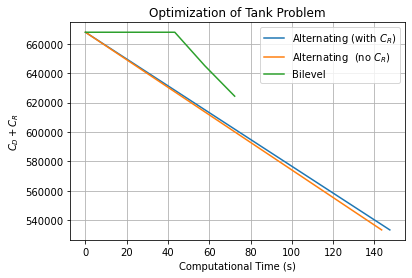

In [25]:
fig = plt.figure()
fhist_alt_plot = [min(fhist_alt[:f+1]) for f,_ in enumerate(fhist_alt)]
plt.plot(thist_alt, fhist_alt_plot, label="Alternating (with $C_R$)")

fhist_alt_nocr_plot = [min(fhist_alt_nocr[:f+1]) for f,_ in enumerate(fhist_alt_nocr)]
plt.plot(thist_alt_nocr, fhist_alt_nocr_plot, label="Alternating  (no $C_R$)")

thist_bilevel_plot = [0]+llargs_bi['thist']
fhist_bilevel_plot = [fhist_alt[0]]+llargs_bi['fhist']
fhist_bilevel_plot = [min(fhist_bilevel_plot[:f+1]) for f,_ in enumerate(fhist_bilevel_plot)]
plt.plot(thist_bilevel_plot, fhist_bilevel_plot, label="Bilevel")
#plt.plot(t, [fhist_alt[0]]+llargs_bi['fhist'], label="Bilevel")
plt.title("Optimization of Tank Problem")
plt.grid()
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")
plt.legend()

In [26]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [27]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_l$", "$f^*$", "time"])
tab.loc['Bilevel'] = list(result_bi['x']) +  [result_bi['fun'], llargs_bi['thist'][-1]]
tab.loc['Alt. (no $C_R$)'] = list(result_alt_nocr['x']) + [llargs_alt_nocr['ll_opt'], thist_alt_nocr[-1]]
tab.loc['Alt. (with $C_R$)'] = list(result_alt['x']) + [result_alt['fun'], thist_alt[-1]]
tab.loc['Seq. (with $C_R$)'] = list(xdhist_alt[1]) + [fhist_alt[1], thist_alt[1]]
tab.loc['Seq. (no $C_R$)'] = list(xdhist_alt_nocr[1]) + [fhist_alt_nocr[1], thist_alt_nocr[1]]

In [28]:
tab

,$x_t$,$x_l$,$f^*$,time
Bilevel,18.9,0.5375,624332.395833,72.296385
Alt. (no $C_R$),10.0,0.0000,533333.333333,143.521800
Alt. (with $C_R$),10.0,0.0000,533333.333333,147.489022
Seq. (with $C_R$),10.0,0.0000,533333.333333,147.489022
Seq. (no $C_R$),10.0,0.0000,533333.333333,143.521800


Note that these are the previously-recorded results:

|               |    𝑥_t      |   𝑥_l   |       𝑓     |    time     |
|--------------------|----------:|---------:|--------------:|------------|
|            Bilevel | 18.000015 | 0.580982 | 285708.991759 | 619.369699 |
|   Alt. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 | 168.275383 |
| Alt. (with  𝐶 𝑅CR) | 20.000000 | 0.000000 | 452666.666823 | 306.776320 |
| Seq. (with  𝐶 𝑅CR) | 22.000000 | 0.000000 | 466333.333389 |  61.702104 |
|   Seq. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 |  55.957946 |

As shown, the results are consistent (not exactly, since the lower-level EA is a stochastic search), and this problem gives better results from a bilevel search as expected. However, the optimization is somewhat slower, so it may (still) be helpful to implement interfaces manually to avoid some model instantiation overhead.